# COVID-19 and Viral Pneumonia Detection Tool
### 1. Loading and Exploring Dataset

In [10]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data_path = pathlib.Path("/Users/jiangjiang/Downloads/COVID_IEEE")  
assert data_path.exists(), "Dataset folder not found"

In [3]:
# === Count Images in Each Class ===
counts = {folder.name: len(list(folder.glob("*")))
          for folder in data_path.iterdir() if folder.is_dir()}

print("Number of images in each class:")
for label, count in counts.items():
    print(f"{label}: {count}")

Number of images in each class:
normal: 668
covid: 536
virus: 619


In [4]:
# === Create Data Frame ===
data = [(str(img), folder.name) for folder in data_path.iterdir() if folder.is_dir() for img in folder.glob("*")]
df = pd.DataFrame(data, columns=["filepath", "label"])

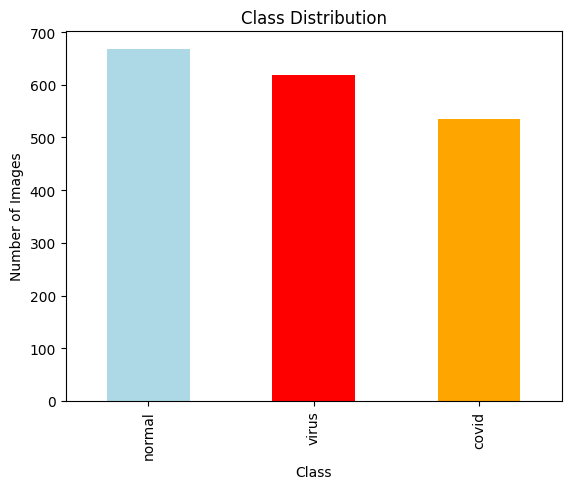

In [5]:
# ==== Class Distribution ===
df["label"].value_counts().plot(kind="bar", color=['lightblue','red','orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Found 1708 files belonging to 3 classes.


2025-10-24 21:21:55.748315: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-10-24 21:21:55.748395: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-10-24 21:21:55.748399: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.66 GB
2025-10-24 21:21:55.748434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-24 21:21:55.748459: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-10-24 21:21:56.116968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


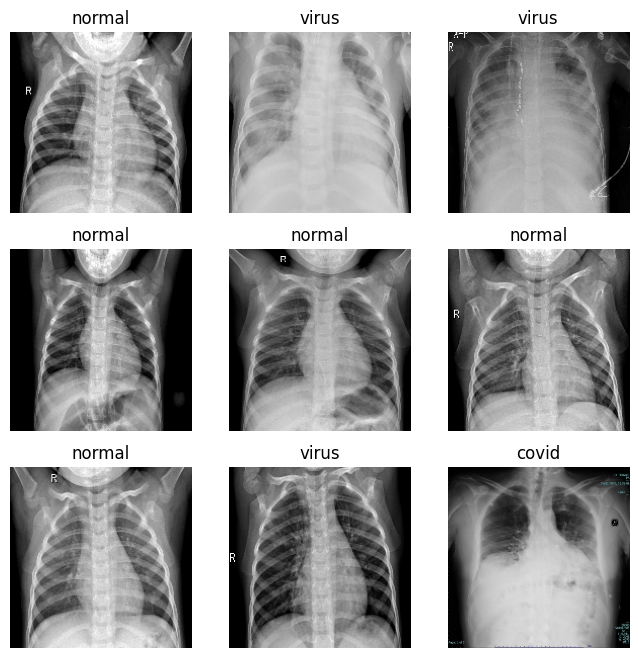

In [6]:
# === Load/Display Images ===
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(180, 180),
    batch_size=9,
    shuffle=True
)

class_names = dataset.class_names
plt.figure(figsize=(8,8))
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 2. Build & Train Baseline CNN Model

Training set size: 1458
Test set size: 365
Classes: ['covid', 'normal', 'virus']

Class distribution in training set
label
normal    534
virus     495
covid     429
Name: count, dtype: int64

Class distribution in test set
label
normal    134
virus     124
covid     107
Name: count, dtype: int64


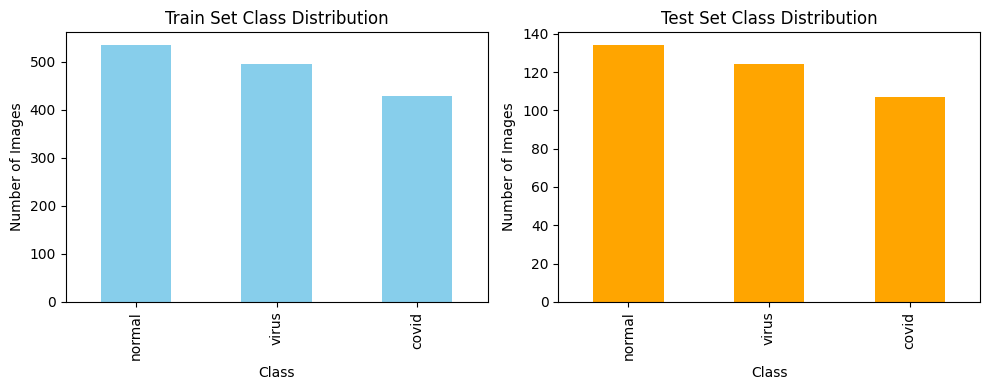

In [7]:
# ---- Split into train / test ----
from sklearn.model_selection import train_test_split

# Encode labels numerically
class_names = sorted(df["label"].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
df["y"] = df["label"].map(class_to_idx)

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["y"], random_state=66
)
print("Training set size:", len(train_df))
print("Test set size:", len(test_df))

img_size = (180, 180)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["filepath"].values, train_df["y"].values)
).map(load_and_preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df["filepath"].values, test_df["y"].values)
).map(load_and_preprocess, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

num_classes = len(class_names)
print("Classes:", class_names)

print("\nClass distribution in training set")
print(train_df["label"].value_counts())

print("\nClass distribution in test set")
print(test_df["label"].value_counts())

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

train_df["label"].value_counts().plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Train Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Images")

test_df["label"].value_counts().plot(kind="bar", ax=axes[1], color="orange")
axes[1].set_title("Test Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Number of Images")

plt.tight_layout()
plt.show()

In [8]:
# ---- Baseline CNN ----
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=img_size + (3,)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

# ---- Train ----
history = model.fit(
    train_ds,
    epochs=10,
    verbose=1
)

# ---- Evaluate on test ----
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

Epoch 1/10


/opt/anaconda3/envs/cxr-mac/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-24 21:21:56.967395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.7058 - loss: 0.9912
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9067 - loss: 0.2731
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9177 - loss: 0.2250
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9403 - loss: 0.1444
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9684 - loss: 0.1002
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9815 - loss: 0.0483
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9897 - loss: 0.0331
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9904 - loss: 0.0412
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9829 - loss: 0.0527
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9959 - loss: 0.0159
Test loss: 0.2115 | Test accuracy: 0.9534


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

y_true = []
y_pred = []

for imgs, labels in test_ds:
    probs = model.predict(imgs, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\nClassification Report\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


Classification Report

              precision    recall  f1-score   support

       covid       0.97      0.97      0.97       107
      normal       0.94      0.93      0.94       134
       virus       0.95      0.96      0.96       124

    accuracy                           0.95       365
   macro avg       0.95      0.95      0.95       365
weighted avg       0.95      0.95      0.95       365



2025-10-24 21:23:29.131899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


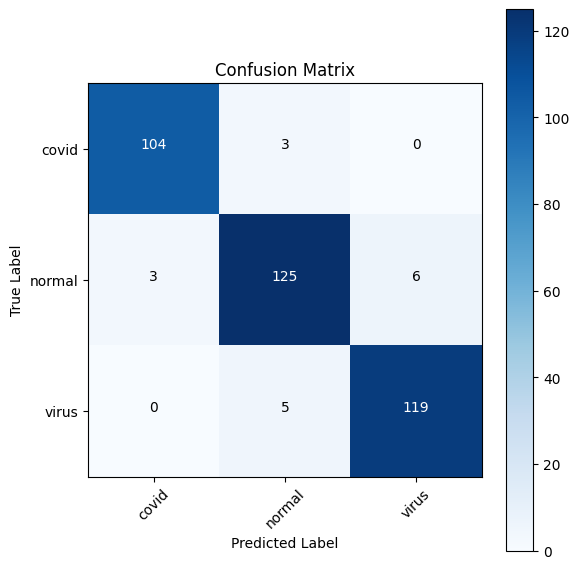

In [12]:
# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

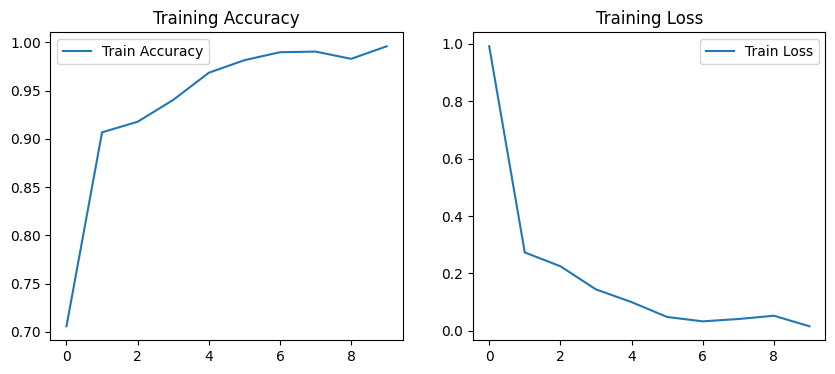

In [13]:
# ---- Accuracy and Loss curves ----
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

### 3. Model Improvement

### 4. Evaluate Model Performances